# HR Analytics

For this project, I'm using a public dataset found here:
https://www.kaggle.com/ludobenistant/hr-analytics



In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('HR_comma_sep.csv')

data.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,years_with_company,work_accident,left,promotion_last_5years,dept,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# In a real-world setting, it would be better to have actual
# dollar amounts. It would make our models much more accurate.

# I'm estimating that high salaries are twice as much as the
# average/medium salaries, so I'm using a scale of 1, 2, and 4.

salary_dict = {
    'low': 1,
    'medium': 2,
    'high': 4
}

data['salary'] = data['salary'].map(salary_dict)

We can either label encode or dummify the categorical variables. I chose to dummify them because there weren't too many values and it didn't significantly increase the dimensionality of our data.

In [4]:
for i in data.columns:
    if data[i].dtype == 'O':
        dums = pd.get_dummies(data[i], prefix=str(i))
        #dums.rename(columns=lambda x: str(i) + '_' + x, inplace=True)
        del data[i]
        data = pd.concat([data, dums], axis=1)

# 19 features and 14999 records
data.shape

(14999, 19)

Now let's examine the correlations between each variable.

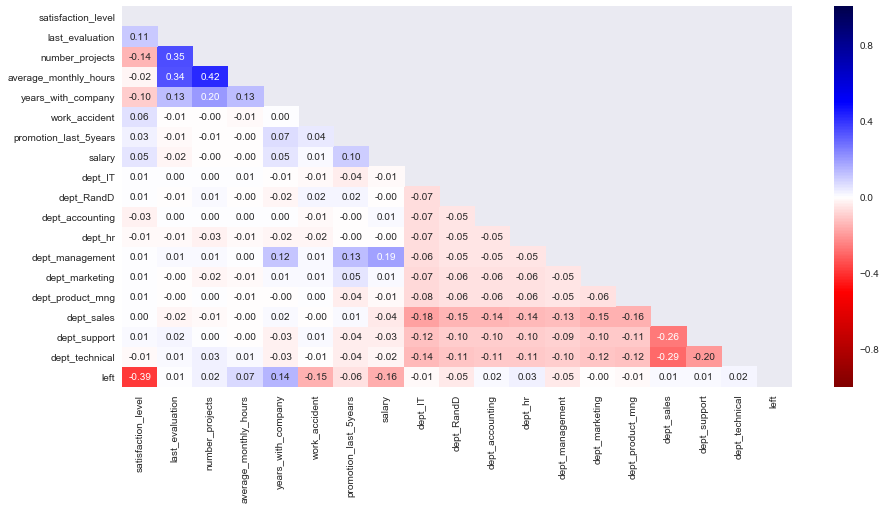

In [5]:
# Move our target variable to the bottom
left = data.pop('left')
data['left'] = left

corrs = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Resize and display
plt.figure(figsize=(15,7))
sns.heatmap(corrs, annot=True, fmt='.2f', mask=mask, cmap='seismic_r')

The strongest predictor of whether an employee leaves is their job satisfaction. No surprises there.

More senior employees are more likely to leave, and those with higher salaries are less likely to leave. Let's plot some of the more important variables.

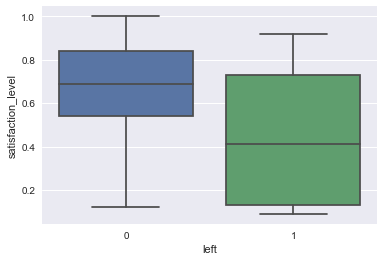

In [6]:
sns.boxplot(x='left', y='satisfaction_level', data=data)

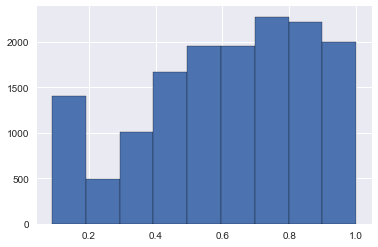

In [7]:
data.satisfaction_level.hist(edgecolor='black', bins=9)

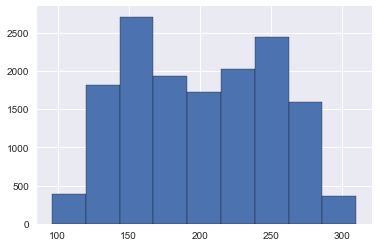

In [8]:
# Interesting bimodal distribution here
data.average_monthly_hours.hist(edgecolor='black', bins=9)

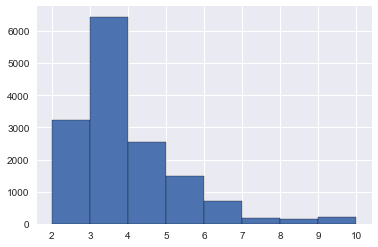

In [9]:
data.years_with_company.hist(edgecolor='black', bins=8)

# Machine Learning

Let's create a model to predict employee retention!

After trying a few different algorithms, including Logistic Regression, Naive Bayes, K-Nearest Neighbors, and XGBoost, I found that a simple **decision tree** was the best choice. Not only was it among the most accurate, but its results and recommendations can be interpreted easily by non-technical people.

In [10]:
x = data.drop('left', axis=1)
y = data['left']

In [11]:
# Comparing Algorithms

lr_cvs = cross_val_score(LogisticRegression(), x, y, cv=5,
                         scoring='accuracy').mean()
nb_cvs = cross_val_score(GaussianNB(), x, y, cv=5,
                         scoring='accuracy').mean()
kn_cvs = cross_val_score(KNeighborsClassifier(n_neighbors=3), x, y, cv=5,
                         scoring='accuracy').mean()
xg_cvs = cross_val_score(XGBClassifier(n_estimators=500), x, y, cv=5,
                         scoring='accuracy').mean()
tree_cvs = cross_val_score(DecisionTreeClassifier(max_depth=9), x, y, cv=5,
                         scoring='accuracy').mean()

print('ACCURACY RESULTS')
print('Logistic regression:', lr_cvs)
print('Naive Bayes:', nb_cvs)
print('KNN:', kn_cvs)
print('XGBoost:', xg_cvs)
print('Decision tree:', tree_cvs)

ACCURACY RESULTS
Logistic regression: 0.770710294516
Naive Bayes: 0.697253402769
KNN: 0.936396507385
XGBoost: 0.977731665296
Decision tree: 0.978198220933


## Evaluating the model

Is accuracy really the best metric for evaluating our model?

I would argue it is not. I would argue it is not. What we're really interested in is identifying which employees are at high risk of leaving. Because of this, we should optimize for **recall**. Our model should know a dissatisfied employee when it sees one, even at the risk of some false positives.

In [12]:
lr_cvs = cross_val_score(LogisticRegression(), x, y, cv=5,
                         scoring='recall').mean()
nb_cvs = cross_val_score(GaussianNB(), x, y, cv=5,
                         scoring='recall').mean()
kn_cvs = cross_val_score(KNeighborsClassifier(n_neighbors=3), x, y, cv=5,
                         scoring='recall').mean()
xg_cvs = cross_val_score(XGBClassifier(n_estimators=500), x, y, cv=5,
                         scoring='recall').mean()
tree_cvs = cross_val_score(DecisionTreeClassifier(max_depth=9), x, y, cv=5,
                         scoring='recall').mean()

print('RECALL RESULTS')
print('Logistic regression:', lr_cvs)
print('Naive Bayes:', nb_cvs)
print('KNN:', kn_cvs)
print('XGBoost:', xg_cvs)
print('Decision tree:', tree_cvs)

RECALL RESULTS
Logistic regression: 0.369646431999
Naive Bayes: 0.796414174061
KNN: 0.94706274118
XGBoost: 0.940631525337
Decision tree: 0.939789622143


Now we see that KNN, XGBoost, and Decision Trees are all excellent choices, while a logistic regression is not.

XGBoost has built-in functionality to display feature importances, so let's take a look at what predicts retention.

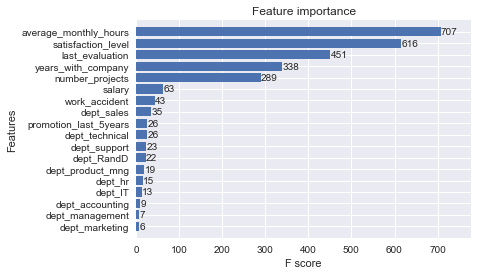

In [13]:
from xgboost import plot_importance

# We already cross-validated, so we can fit
# to the entire data set for illustrative purposes
xg = XGBClassifier(n_estimators=500).fit(x,y)

plot_importance(xg, height=.8)
plt.show()

Interestingly, it's not employee satisfaction that XGBoost finds the most important -- it's average monthly hours.

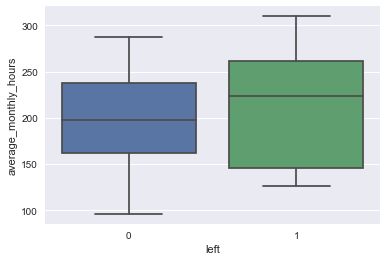

In [14]:
sns.boxplot(x='left', y='average_monthly_hours', data=data)

Perhaps some employees are feeling overworked? This is certainly something I'd investigate further.

When we plot performance review scores, we see a similar trend: it's the hardest workers who are leaving most!

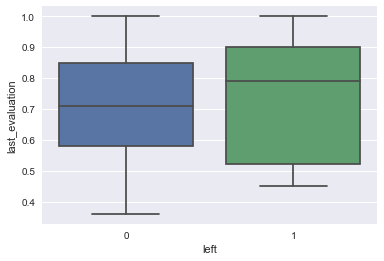

In [15]:
sns.boxplot(x='left', y='last_evaluation', data=data)

## CAP Curve

I like to visualize my classifiers by plotting the Cumulative Accuracy Profile. This ranks employees by how likely they are to quit, and compares the model's predictions to selecting employees by random chance.

In [16]:
xtrain, xtest, ytrain, ytest =\
train_test_split(x, y, test_size=0.25)

cap_tree = DecisionTreeClassifier(max_depth=9).fit(xtrain, ytrain)

pred_proba = cap_tree.predict_proba(xtest)[:,1]

In [17]:
results = pd.DataFrame()

results['actual'] = ytest
results['predicted'] = pred_proba

results.sort_values('predicted', ascending=False, inplace=True)

# Counting positive observations
results['model_count'] = pd.Series.cumsum(results.actual)
results['percentage'] = 1/len(results)
results['random_count'] = pd.Series.cumsum(results['percentage']) * np.sum(results['actual'])

# Percentage of the total found
results['model_select_pct'] = results['model_count']/np.sum(results['actual'])
results['random_select_pct'] = pd.Series.cumsum(results.percentage)

del results['percentage']

In [18]:
results.head(10)

,actual,predicted,model_count,random_count,model_select_pct,random_select_pct
309,1,1.0,1,0.249333,0.001070,0.000267
811,1,1.0,2,0.498667,0.002139,0.000533
1727,1,1.0,3,0.748000,0.003209,0.000800
1589,1,1.0,4,0.997333,0.004278,0.001067
12071,1,1.0,5,1.246667,0.005348,0.001333
522,1,1.0,6,1.496000,0.006417,0.001600
1365,1,1.0,7,1.745333,0.007487,0.001867
843,1,1.0,8,1.994667,0.008556,0.002133
1992,1,1.0,9,2.244000,0.009626,0.002400
663,1,1.0,10,2.493333,0.010695,0.002667


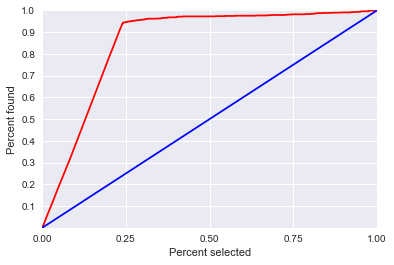

In [19]:
def plot_cap_curve(df):
    plt.plot(df.random_select_pct, df.model_select_pct, color='red')
    plt.plot(df.random_select_pct, df.random_select_pct, color='blue')

    plt.ylabel('Percent found')
    plt.xlabel('Percent selected')

    plt.ylim(0,1)
    plt.xlim(0,1)

    plt.xticks([0, .25, .5, .75, 1])
    plt.yticks([.1, .2, .3, .4,
                .5, .6, .7, .8, .9, 1])

    from pylab import rcParams
    rcParams['figure.figsize'] = 10, 6

plot_cap_curve(results)

Honestly, I've never seen a model perform this well! For the top 25% of employees most likely to quit, our model is practically a crystal ball. We really lucked out by having high-quality data!

# Recommendations

A decision tree is the best choice here because it's both **a)** highly accurate, and **b)** understandable by humans. Let's look at what it recommends!

In [20]:
# Fit to all data
tree = DecisionTreeClassifier(max_depth=9).fit(x, y)

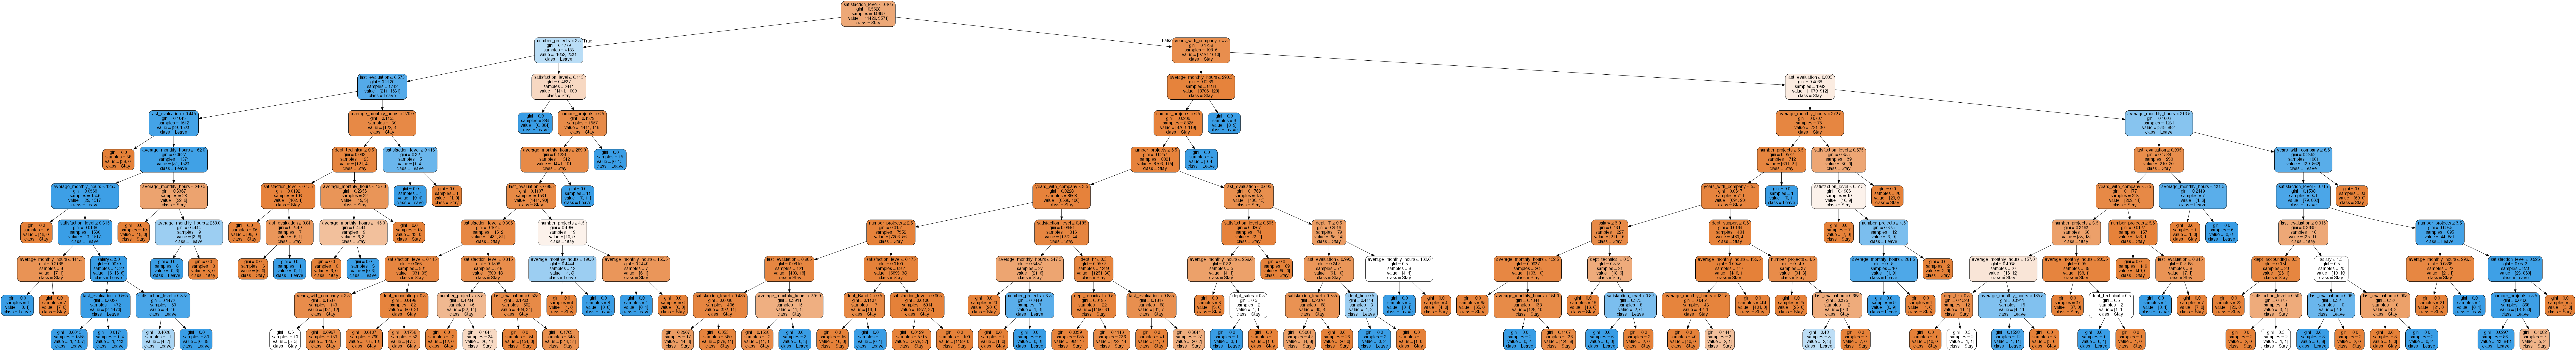

In [21]:
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Stay', 'Leave'],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

That's one heck of a tree! It *might* be useful in some circumstances, but it's probably better to sacrifice some accuracy for readability. Let's use a depth of 3 instead of 9.

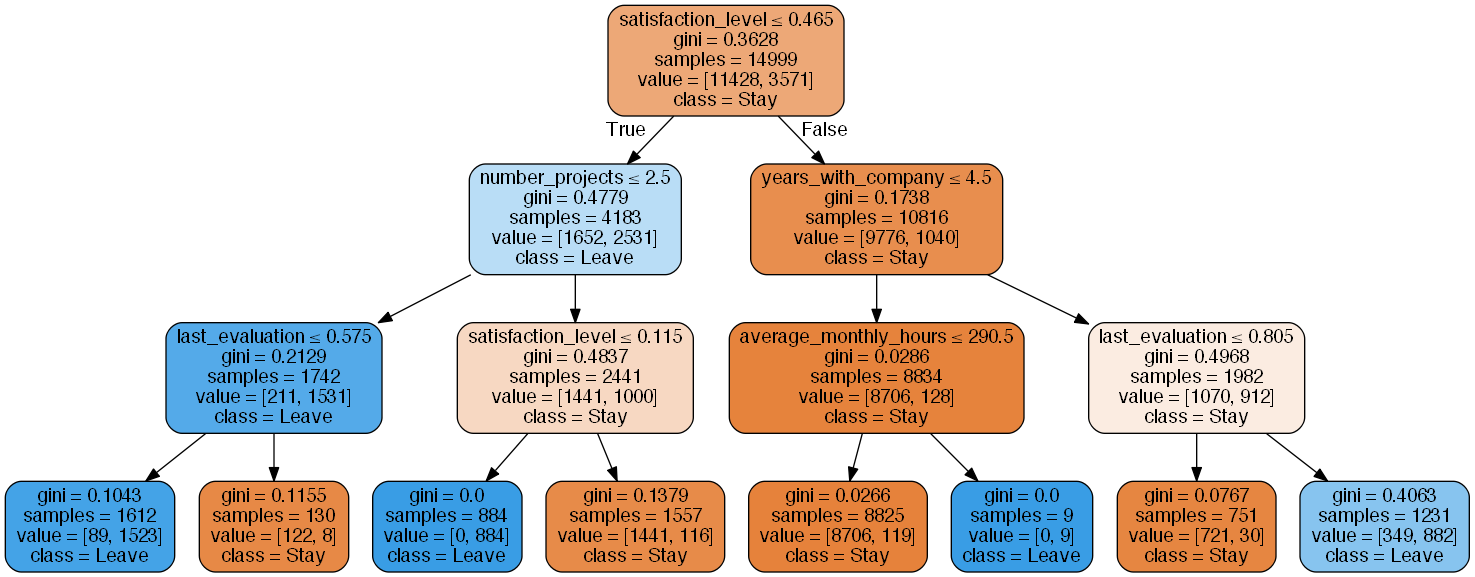

In [22]:
tree = DecisionTreeClassifier(max_depth=3).fit(x,y)

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Stay', 'Leave'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

My advice to management would be:

- Pay close attention to employee satisfaction levels. This is a great overall predictor of retention.

 
- Among dissatisfied employees, low performance ratings further contribute to leaving the company.

 
- It's a bit harder to predict retention among satisfied employees. Those with the longest tenure are more likely to leave, especially if they are high performers. This suggests that there isn't enough room for advancement at the higher levels of the company.

 
- If promotions are out of the question, we should experiment with higher salaries, flextime, or other incentives that would encourage people to stay.